1. Test sklearn’s TfidfVectorizer inplace of CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value?
2. Test different lengths of n-grams in the CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value? Do these n-grams show up also in the list of most significant positive/negative features?
3. In the data package for the course (http://dl.turkunlp.org/intro-to-nlp.tar.gz), the directory language_identification contains data for 5 languages. Based on this data, train an SVM classifier for language recognition between these 5 languages.
4. If you completed (3), toy around with features, especially the ngram_range and analyzer parameters, which allow you to test classification based on character ngrams of various lengths (not only word n-grams). Gain some insight into the accuracy of the classifier with different features, and try to identify misclassified documents - why do you think they were misclassified?
5. On the address universal dependencies.org, you will find datasets for a bunch of languages. These come in an easy-to-parse, well-documented format. Pick one language that interests you, and one tree bank for that language, and try to build a POS tagger for this language. You can use the 4th column “UPOS” https://universaldependencies.org/format.htmlReportonyourfindings. If you have extra time, try to experiment with various features and see if you can make your accuracy go up. You can check here https://universaldependencies.org/conll18/results-upos.html what the state of the art roughly is for your selected language and treebank. Did you come close?


In [26]:
import os
import json
import random
import conllu
# import sklearn
import mglearn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
def draw_param_heatmap(
    param_grid,
    x_grid, y_grid,
    df_result,
    summarize='mean'
):
    """
    Draw a heatmap based on 2 parameters grid.
    
    Parameters:
    ----------
    
    param_grid: dict
        Provide the dictionary of parameters,
        the names of the parameterr provide in x_grid
        and y_grid should be available in this dictionary
    x_grid: string/object
        Name of the parameter to be plotted
        on the x axis. The name should be exactly same
        as one of the key in the 'param_grid'
    y_grid: string/object
        Name of the parameter to be plotted
        on the y axis. The name should be exactly same
        as one of the key in the 'param_grid'
    df_result: Pandas Dataframe
        Obtain from the 'cv_results_' attribute of GridSearch
    summarize: string/object
        Choose the summarization method for the score
        since there are more than 1 score. And unless 'sum'
        is explicitly stated, the score will always be
        mean/average
    
    Returns:
    -------
    None:
        No return, just plot the heatmap
    """

    # Prepare an empty dataframe
    df_heatmap = pd.DataFrame(
        index=param_grid[y_grid],
        columns=param_grid[x_grid],
        dtype=np.float32
    )

    # Fill the empty data frame
    # With total score from other parameters
    col_min = None
    col_max = None
    for k, i in enumerate(param_grid[y_grid]):
        for l, j in enumerate(param_grid[x_grid]):
            if summarize == 'sum':
                df_heatmap.loc[i, j] = df_result[
                    (df_result['param_'+y_grid] == i) &
                    (df_result['param_'+x_grid] == j)
                ]['mean_test_score'].sum()
            else:
                df_heatmap.loc[i, j] = df_result[
                    (df_result['param_'+y_grid] == i) &
                    (df_result['param_'+x_grid] == j)
                ]['mean_test_score'].mean()
            if not col_max:
                col_max = df_heatmap.iloc[k, l]
            else:
                col_max = max(
                    col_max, df_heatmap.iloc[k, l]
                )
            if not col_min:
                col_min = df_heatmap.iloc[k, l]
            else:
                col_min = min(
                    col_min, df_heatmap.iloc[k, l]
                )

    # Plot the heatmap
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['lines.linewidth'] = 5.0
    plt.rcParams['lines.markersize'] = 15.0
    mglearn.tools.heatmap(
        np.array(df_heatmap),
        xlabel=x_grid,
        xticklabels=param_grid[x_grid],
        ylabel=y_grid,
        yticklabels=param_grid[y_grid],
        cmap='bwr',
        vmax=col_max,
        vmin=col_min
    )


def sort_dictionary_value(dictionary, descending=False, dtype='dict'):
    """
    Sort a dictionary by its values.
    
    Parameters:
    ----------
    
    dictionary: dict
        A dictionary with sortable value (i.e. int)

    descending: boolean
        Sort by ascending or descending order

    dtype: str
        Choose output type, either dict or list
    
    Returns:
    -------
    sorted: dict or list
        A dictionary sorted by value
    """
    if dtype == 'dict':
        return {
            i: j for i, j in
            sorted(
                dictionary.items(),
                key=lambda x: x[1],
                reverse=descending
            )}
    if dtype == 'list':
        return sorted(
            dictionary.items(),
            key=lambda x: x[1],
            reverse=descending
        )
    print('dtype can only be either "dict" or "list"')
    return None

def shuffle_pair(a, b):
    """
    Shuffle a pair of list.
    
    Parameters:
    ----------
    
    a: list
        A list of values.

    b: list
        A list of values.
    
    Returns:
    -------
    shuffled_a: list
        First list shuffled.
    
    shuffled_b: list
        Second list shuffle correspond to a

    """
    
    if len(a) != len(b):
        print('Lengths of first and second list are different.')
        return None
    c = list(zip(a, b))
    random.shuffle(c)
    shuffled_a, shuffled_b = zip(*c)
    return shuffled_a, shuffled_b

one_word = namedtuple(
    'one_word',
    ['word', 'pos']
)

def parse_conllu(txt):
    """
    Parse a conllu sentence.
    
    Parameters:
    ----------
    
    txt: str
        A sentence in the form of a word
        with multiple tags each line.
    
    Returns:
    -------
    word_tag: list
        A list of named tuple with a word
        and UPOS tag for each item.
    """

    parsed = conllu.parse(txt)
    word_tag = []
    for word in parsed[0]:
        word_tag.append(
            one_word(*(
                word['form'],
                word['upostag']
            ))
        )
    return word_tag

def read_conllu(file):
    """
    Read a conllu file.
    
    Parameters:
    ----------
    
    file: .conllu file
        Words with their tags available
    
    Returns:
    -------
    doc: list
        A list of sentences,
        each sentence is a list of words.
    """

    doc = []
    current_sentence = ''
    with open(file) as f:
        for line in f:
            if line[0] == '#':
                continue
            if line == '\n':
                if current_sentence:
                    doc.append(
                        parse_conllu(current_sentence)
                    )
                    current_sentence = ''
                continue
            current_sentence += line
        else:
            if current_sentence:
                doc.append(
                    parse_conllu(current_sentence)
                )
    return doc

def generate_sentence_features(sentence):
    """
    Generate a feature matrix for each element in a sentence.
    
    Parameters:
    ----------
    
    sentence: list
        A list of (word, POS tag) tuple.
    
    Returns:
    -------
    sentence_features: list
        A list of features per element in the sentence.
    """

    sentence_features = []
    for i, word in enumerate(sentence):
        word_features={}
        # The word itself should be a features
        word_features['word_' + word.word] = 1
        # Then Vietnamese words depend heavily
        # on the word before and after it
        # to form meanings.
        # Though not more than that,
        # certain words have no meaning
        # standing alone as well.
        # So before and after are good enough
        if i == 0:
            word_features['word_previous_'] = 1
        else:
            word_features[
                'word_previous_'
                + sentence[i-1].word
            ] = 1
        if i == len(sentence) - 1:
            word_features['word_next_'] = 1
        else:
            word_features[
                'word_next_'
                + sentence[i+1].word
            ] = 1
        # There are a lot of double words in Vietnamese
        # separated by a space
        # Individually they mean different thing,
        # or just make no sense at all
        # and they are usually ADJ or NOUN, to my knowledge
        if ' ' in word.word:
            word_features['has_space'] = 1
        else:
            word_features['has_space'] = 0
        sentence_features.append(word_features)
    return sentence_features

def prep_data(sentences):
    """
    Split data into features and labels.
    
    Parameters:
    ----------
    
    sentences: list
        A list of sentences in form of (word, POS) tuples.
    
    Returns:
    -------
    all_labels: list
        A list of POS label for each element in each sentence.
    all_features: lít
        A list of features for each element in each sentence.
    """

    all_labels = []
    all_features = []
    for sentence in sentences:
        sentence_features = generate_sentence_features(sentence)
        assert len(sentence_features) == len(sentence)
        for word, features in zip(sentence, sentence_features):
            all_labels.append(word.pos)
            all_features.append(features)
    return all_labels, all_features

In [2]:
with open('Data/imdb_train.json') as f:
    data = json.load(f)
random.shuffle(data)
print('class label:', data[0]['class'])
print('text:', data[0]['text'])

class label: pos
text: I am a member of a canoeing club and I can tell you the truth that Deliverance is synonomous with the peacefulness and tranquility of the experience. As we put our boats into the water, banjoes echo in the back of the conscious mind. This movie is timeless because it waxes philosophical of human's place in nature and technology's effect upon man's relationship with nature. We see it in the bow fishing. We see it in the home made tent. There is also city man's disdain and feeling of superiority to the rural woodsman \cracker\". The fact that the Banker from Atlanta (Ned Beatty) has \"bad teeth\" is meant to put him on the same level with the woodsmen who also have bad teeth. Ultimately, the struggle of life and death supersedes \"civilized man's\" suppositives about \"The Law\". This canoe trip ends too soon for the viewer, but alas Not Soon Enough for the characters."


In [3]:
# We need to gather the texts and labels into separate lists
texts = [one_example['text'] for one_example in data]
labels = [one_example['class'] for one_example in data]
print('This many texts', len(texts))
print('This many labels', len(labels))
print()
for label, text in list(zip(labels, texts))[:20]:
    print(label, text[:50]+'...')

This many texts 25000
This many labels 25000

pos I am a member of a canoeing club and I can tell yo...
neg I have just watched the movie for the first time. ...
pos This show is awesome! and I've seen it about 6 tim...
neg The name of Nick Stahl, the young cast and the att...
neg This film takes what could have been a good idea, ...
pos My kids recently started watching the reruns of th...
neg Ah, Channel 5 of local Mexican t.v. Everyday, at 2...
neg Having seen the first ten episodes, I must say thi...
neg The reason the DVD releases of this film are in bl...
neg Damp telling of the American Revolution.  When far...
pos There have been countless talking-animal films in ...
neg I really looked forward to see Planet of the Apes,...
neg Not sure why this movie seems to have gotten such ...
neg Camera work - Why is the camera work in this movie...
pos After Racism, Rural exodus -also known as migratio...
pos The world of the Dragon Hunters is a 3D gravity ch...
pos \The Invisible Ray\" i

In [4]:
# Check what's the different between count and tfidf
vectorizer = TfidfVectorizer()

toy_data = [
    'Rust has great documentation, ',
    'a friendly compiler with useful error messages, ',
    'and top-notch tooling — an integrated package manager and build tool, ',
    'smart multi-editor support with auto-completion and type inspections, ',
    'an auto-formatter, and more.'
]

vectorizer.fit(toy_data)
print('Unique features:')
print(vectorizer.get_feature_names())
print()
print('Feature vectors (sparse format):')
print(vectorizer.transform(toy_data))

Unique features:
['an', 'and', 'auto', 'build', 'compiler', 'completion', 'documentation', 'editor', 'error', 'formatter', 'friendly', 'great', 'has', 'inspections', 'integrated', 'manager', 'messages', 'more', 'multi', 'notch', 'package', 'rust', 'smart', 'support', 'tool', 'tooling', 'top', 'type', 'useful', 'with']

Feature vectors (sparse format):
  (0, 21)	0.5
  (0, 12)	0.5
  (0, 11)	0.5
  (0, 6)	0.5
  (1, 29)	0.3393931489111758
  (1, 28)	0.4206690600631704
  (1, 16)	0.4206690600631704
  (1, 10)	0.4206690600631704
  (1, 8)	0.4206690600631704
  (1, 4)	0.4206690600631704
  (2, 26)	0.3094185760868625
  (2, 25)	0.3094185760868625
  (2, 24)	0.3094185760868625
  (2, 20)	0.3094185760868625
  (2, 19)	0.3094185760868625
  (2, 15)	0.3094185760868625
  (2, 14)	0.3094185760868625
  (2, 3)	0.3094185760868625
  (2, 1)	0.41444245308083316
  (2, 0)	0.2496369589290994
  (3, 29)	0.27274066223567134
  (3, 27)	0.3380550208269348
  (3, 23)	0.3380550208269348
  (3, 22)	0.3380550208269348
  (3, 18)	0.33

Each features are assigned a idf score instead of frequency

In [6]:
# With Validation
# train_text_set, test_texts, train_label_set, test_labels = train_test_split(
#     texts, labels,
#     test_size=0.2, random_state=4
# )
# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     train_text_set, train_label_set,
#     test_size=0.2, random_state=4
# )

# Without Validation
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels,
    test_size=0.2, random_state=4
)

vectorizer = TfidfVectorizer(
    max_features=100000,
    binary=True,
    ngram_range=(1,1)
)

feature_matrix_train = vectorizer.fit_transform(train_texts)
feature_matrix_test = vectorizer.transform(test_texts)

print(feature_matrix_train.shape)
print(feature_matrix_test.shape)

(20000, 68247)
(5000, 68247)


In [7]:
classifier = LinearSVC(
    C=0.0005,
    verbose=1
)

classifier.fit(
    feature_matrix_train,
    train_labels
)

[LibLinear]

LinearSVC(C=0.0005, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [8]:
print('Test set score', classifier.score(feature_matrix_test, test_labels))
print('Train set score:', classifier.score(feature_matrix_train, train_labels))

Test set score 0.8284
Train set score: 0.84435


With the same parameters in the `vectorizer` and the `svm`, vectorizing the string by *idf* score probably gave the `svm` more information so it's less forgiving in classifying task. Next, I'll use `GridSearch` to alter `C`

In [18]:
pipe_tfidf = Pipeline(
    steps=[
        (
            'vectorize',
            TfidfVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

In [19]:
pipe_tfidf.fit(train_texts, train_labels)
print('Test set score', pipe_tfidf.score(test_texts, test_labels))
print('Train set score:', pipe_tfidf.score(train_texts, train_labels))

[LibLinear]Test set score 0.8284
Train set score: 0.84435


So the pipe works, now use it for GridSearchCV

In [20]:
pipe_tfidf = Pipeline(
    steps=[
        (
            'vectorize',
            TfidfVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_tfidf = {
    'vectorize__ngram_range': [
        (1, 1),
        (1, 2),
        (2, 2),
        (1, 3),
        (2, 3)
    ],
    'classify__C': np.logspace(
        -4, 4, 5
    )
}

In [21]:
grid_tfidf = GridSearchCV(
    pipe_tfidf,
    grid_param_tfidf,
    cv=5,
    n_jobs=4,
    verbose=1
)

In [22]:
grid_tfidf.fit(train_texts, train_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 17.3min finished


[LibLinear]

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [31]:
print('The best combination is as follow:')
for param, value in grid_tfidf.best_params_.items():
    if 'vectorize' in param:
        print('tfidf {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

The best combination is as follow:
SVC C: 1.0
tfidf ngram_range: (1, 2)


In [24]:
grid_tfidf.best_estimator_.score(test_texts, test_labels)

0.8984

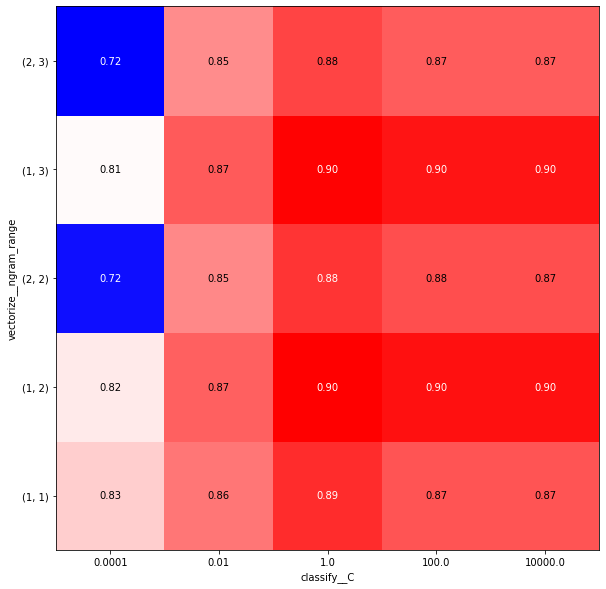

In [63]:
result_tfidf = pd.DataFrame(grid_tfidf.cv_results_)
draw_param_heatmap(
    grid_param_tfidf,
    'classify__C',
    'vectorize__ngram_range',
    result_tfidf
)

In [64]:
pipe_count = Pipeline(
    steps=[
        (
            'vectorize',
            CountVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_count = {
    'vectorize__ngram_range': [
        (1, 1),
        (1, 2),
        (2, 2),
        (1, 3),
        (2, 3)
    ],
    'classify__C': np.logspace(
        -4, 4, 5
    )
}

In [65]:
grid_count = GridSearchCV(
    pipe_count,
    grid_param_count,
    cv=5,
    n_jobs=4,
    verbose=1
)

grid_count.fit(train_texts, train_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 18.1min finished


[LibLinear]

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        CountVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [66]:
print('The best combination is as follow:')
for param, value in grid_count.best_params_.items():
    if 'vectorize' in param:
        print('count {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

grid_count.best_estimator_.score(test_texts, test_labels)

The best combination is as follow:
SVC C: 0.01
count ngram_range: (1, 2)


0.886

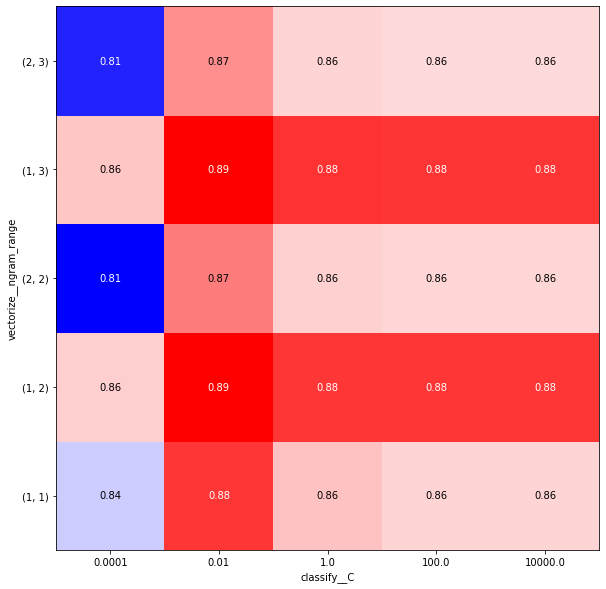

In [67]:
result_count = pd.DataFrame(grid_count.cv_results_)
draw_param_heatmap(
    grid_param_count,
    'classify__C',
    'vectorize__ngram_range',
    result_count
)

Compare to `Tfidf` vectorizing method, `Count` method provides a slightly lower score when pass through a `svm`.

Also the sweet spot of the 2 are also a tad different. While `Count` found its best `C` value at about `C=0.01`, probably because counting didn't take the weight into account while, `Tfidf` already has some degree of that in the weight so it prefers a `C=1`.

However, both shows a better performance in multiple `ngram_range` compare to a single `ngram_range`, meaning `(1, 2)` and `(1, 3)` instead of `(1, 1)` or `(2, 2)`. Humanly speaking that might be because the `svm` is provided about the information about the word itself as well as some form of context.

In [79]:
# # Since I'm doing this in a remote notebook
# # I'll save the trained model for future use
# with open('Model/grid_count.pickle','wb') as f:
#     pickle.dump(grid_count, f)

# with open('Model/grid_count_best.pickle','wb') as f:
#     pickle.dump((
#         grid_count.best_estimator_.steps[0][1],
#         grid_count.best_estimator_.steps[1][1]
#     ), f)

# with open('Model/grid_tfidf.pickle','wb') as f:
#     pickle.dump(grid_tfidf, f)

# with open('Model/grid_ifidf_best.pickle','wb') as f:
#     pickle.dump((
#         grid_tfidf.best_estimator_.steps[0][1],
#         grid_tfidf.best_estimator_.steps[1][1]
#     ), f)

In [120]:
# with open('Model/grid_count.pickle','rb') as f:
#     grid_count = pickle.load(f)

In [127]:
features_count = {
    j: i for i, j
    in grid_count.best_estimator_.steps[0][1].vocabulary_.items()
}

lst_count = [
    (c, i) for i, c in
    enumerate(grid_count.best_estimator_.steps[1][1].coef_[0])
]

lst_count.sort()

In [131]:
for _, i in lst_count[:50]:
    print(features_count[i])
print('----------------------')
for _, i in lst_count[-50:]:
    print(features_count[i])

awful
worst
waste
boring
poorly
terrible
bad
dull
the worst
poor
disappointing
disappointment
save
lacks
mess
annoying
lame
not worth
laughable
horrible
worse
at best
stupid
unfortunately
wonder
waste of
forgettable
oh
not good
just not
dreadful
ridiculous
weak
unfunny
avoid
not even
not recommend
pointless
okay
redeeming
the original
mediocre
pathetic
bored
fails
material
sorry
offensive
way too
than this
----------------------
believable
worth
liked
terrific
powerful
job
fun
10 10
the best
beautiful
much as
underrated
hilarious
enjoyed this
especially
simple
loved this
pretty good
surprisingly
love this
enjoyed
touching
shows
loved
favorite
true
must see
bit
rare
better than
outstanding
very good
wonderfully
definitely worth
to all
fantastic
well worth
refreshing
of what
brilliant
today
amazing
incredible
enjoyed it
wonderful
superb
great
enjoyable
perfect
excellent


Certainly the `ngram_range` had some effects on the features and how the features were used. Words like 'not recommend' was picked up just fine instead of 'recommend' alone for a negative review. Also somehow bad movies are usually sequel because the word 'the original' was quite the determine factor.

#### Now on to the language identification

In [4]:
path_lang = 'language-identification/'
lang_text_train = []
lang_text_val = []
lang_text_test = []
lang_label_train = []
lang_label_val = []
lang_label_test = []
for file in os.listdir(path_lang):
    temp = []
    with open(path_lang + file) as f:
        for line in f:
            temp.append(line)
    if 'train' in file:
        lang_text_train = lang_text_train + temp
        lang_label_train = lang_label_train + [file[:2]]*len(temp)
    if 'devel' in file:
        lang_text_val = lang_text_val + temp
        lang_label_val = lang_label_val + [file[:2]]*len(temp)
    if 'test' in file:
        lang_text_test = lang_text_test + temp
        lang_label_test = lang_label_test + [file[:2]]*len(temp)

In [5]:
print(
    'Number of lines in train text:',
    len(lang_text_train)
)
print(
    'Number of lines in train label:',
    len(lang_label_train)
)
print(
    'Number of lines in validation text:',
    len(lang_text_val)
)
print(
    'Number of lines in validation label:',
    len(lang_label_val)
)
print(
    'Number of lines in test text:',
    len(lang_text_test)
)
print(
    'Number of lines in test label:',
    len(lang_label_test)
)

Number of lines in train text: 5000
Number of lines in train label: 5000
Number of lines in validation text: 5000
Number of lines in validation label: 5000
Number of lines in test text: 5000
Number of lines in test label: 5000


In [6]:
lang_text_train, lang_label_train = shuffle_pair(
    lang_text_train, lang_label_train
)
lang_text_val, lang_label_val = shuffle_pair(
    lang_text_val, lang_label_val
)
lang_text_test, lang_label_test = shuffle_pair(
    lang_text_test, lang_label_test
)

In [7]:
lang_text_train = list(lang_text_train)
lang_label_train = list(lang_label_train)
lang_text_val = list(lang_text_val)
lang_label_val = list(lang_label_val)
lang_text_test = list(lang_text_test)
lang_label_test = list(lang_label_test)

In [8]:
pipe_lang = Pipeline(
    steps=[
        (
            'vectorize',
            TfidfVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_lang = {
    'vectorize__ngram_range': [
        (1, 1),
        (1, 2),
        (2, 2),
        (1, 3),
        (2, 3)
    ],
    'classify__C': np.logspace(
        -4, 4, 5
    )
}

pds = PredefinedSplit(
    test_fold=[-1]*len(lang_label_train)+[0]*len(lang_label_val)
)

grid_lang = GridSearchCV(
    pipe_lang,
    grid_param_lang,
#     cv=5,
    cv=pds,
    n_jobs=4,
    verbose=1
)

In [9]:
grid_lang.fit(
    lang_text_train+lang_text_val,
    lang_label_train+lang_label_val
)

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   18.2s finished


[LibLinear]

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                             

In [10]:
print('The best combination is as follow:')
for param, value in grid_lang.best_params_.items():
    if 'vectorize' in param:
        print('lang {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

grid_lang.best_estimator_.score(lang_text_test, lang_label_test)

The best combination is as follow:
SVC C: 1.0
lang ngram_range: (1, 2)


0.9622

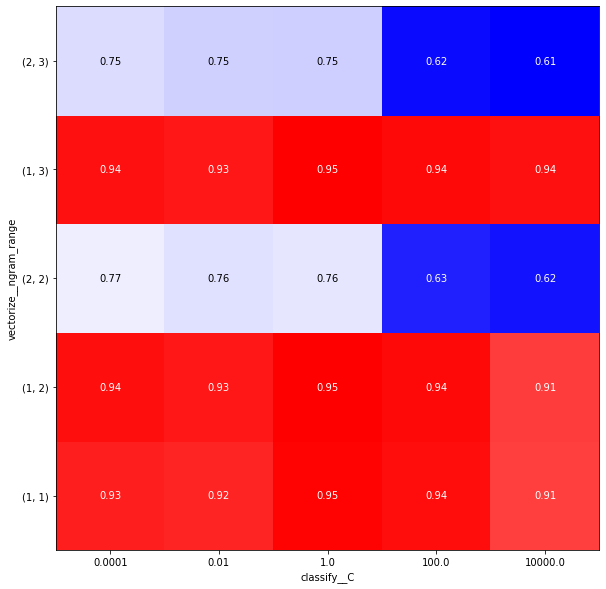

In [11]:
draw_param_heatmap(
    grid_param_lang,
    'classify__C',
    'vectorize__ngram_range',
    pd.DataFrame(grid_lang.cv_results_)
)

In [19]:
features_lang = {
    j: i for i, j
    in grid_lang.best_estimator_.steps[0][1].vocabulary_.items()
}

lst_lang = [
    (c, i) for i, c in
    enumerate(grid_lang.best_estimator_.steps[1][1].coef_[0])
]

lst_lang.sort()

for _, i in lst_lang[:50]:
    print(features_lang[i])
print('----------------------')
for _, i in lst_lang[-50:]:
    print(features_lang[i])

de
ja
em
que
el
se
oli
en
on
ei
por
la
para
aitäh
um
ka
os
mais
não
ta
como
myös
hän
ovat
kui
con
los
eesti
että
et
uma
pole
su
sekä
tai
aga
ning
oma
un
sitten
joka
siis
una
mutta
es
2009
rasmus
rasmus albumilistan
the rasmus
olla
----------------------
out
easy
hi
kay
tana
essie
tks
michelle
there
but
help
hey
never
can
wow
regards
mhc
so
best
pm
your
will
jeff
by
chris
we
not
good
please
thanks
doc
great
this
my
or
am
and
that
with
have
it
you
are
was
for
is
in
of
to
the


At this point I thought of checking whether the dataset was balanced but it was and I just realized `coef_[0]` is the coefficient for English, great

In [176]:
# with open('Model/grid_lang_word.pickle','wb') as f:
#     pickle.dump(grid_lang, f)

# with open('Model/grid_lang_word_best.pickle','wb') as f:
#     pickle.dump((
#         grid_lang.best_estimator_.steps[0][1],
#         grid_lang.best_estimator_.steps[1][1]
#     ), f)

Now try with characters instead of words. But then since `GridSearchCV` has a cross-validation built-in, I'll put the train and validation set together and let `GridSearchCV` do its job instead of using the predefined split

In [12]:
pipe_lang_char = Pipeline(
    steps=[
        (
            'vectorize',
            TfidfVectorizer(
                max_features=100000,
                binary=True,
                ngram_range=(1,1)
            )
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_lang_char = {
    'vectorize__analyzer': [
        'char',
        'char_wb'
    ],
    'vectorize__ngram_range': [
        (5, 5),
        (10, 10),
        (15, 15)
    ],
    'classify__C': np.logspace(
        -4, 4, 5
    )
}

grid_lang_char = GridSearchCV(
    pipe_lang_char,
    grid_param_lang_char,
    cv=5,
    n_jobs=4,
    verbose=1
)

In [14]:
grid_lang_char.fit(
    lang_text_train+lang_text_val,
    lang_label_train+lang_label_val
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.0min finished


[LibLinear]

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=True,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

In [15]:
print('The best combination is as follow:')
for param, value in grid_lang_char.best_params_.items():
    if 'vectorize' in param:
        print('lang_char {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

grid_lang_char.best_estimator_.score(lang_text_test, lang_label_test)

The best combination is as follow:
SVC C: 1.0
lang_char analyzer: char_wb
lang_char ngram_range: (5, 5)


0.9848

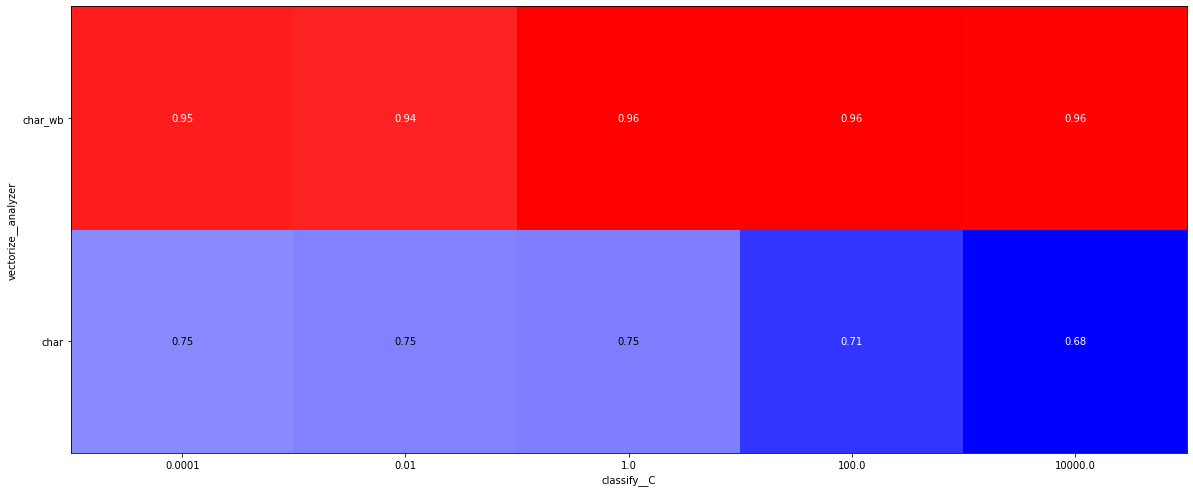

In [18]:
draw_param_heatmap(
    grid_param_lang_char,
    'classify__C',
    'vectorize__analyzer',
    pd.DataFrame(grid_lang_char.cv_results_)
)

I would have thought that the `analyzer=char` would have more effects on the results because it has some more information. But turn out, those information became noises instead and hurted the classifier. But then, for `analyzer=char_wb`, the `ngram_range` that worked was `(5, 5)`. That's only a word long and even less. So it's like less is more at this point as the features now are just linking words, some punctuations and special characters. Different cultural usage?

In [16]:
features_lang_char = {
    j: i for i, j
    in grid_lang_char.best_estimator_.steps[0][1].vocabulary_.items()
}

lst_lang_char = [
    (c, i) for i, c in
    enumerate(grid_lang_char.best_estimator_.steps[1][1].coef_[0])
]

lst_lang_char.sort()

In [17]:
for _, i in lst_lang_char[:50]:
    print(features_lang_char[i])
print('----------------------')
for _, i in lst_lang_char[-50:]:
    print(features_lang_char[i])

 de 
 ja 
 em 
 o 
 en 
 el 
 y 
 " 
 se 
 la 
 ei 
 e 
 oli 
 que 
 por 
 on 
para 
 é 
 fabe
 os 
 « 
 com 
ente 
 para
 un 
 es 
 con 
inen 
 não 
 su 
 um 
 los 
mente
 ka 
aber 
 kui 
 ta 
 una 
 tule
ista 
 como
 et 
ssa. 
ncia 
 fue 
 olen
como 
 esta
 hän 
 uma 
----------------------
 kim 
 sun 
 bd 
tks, 
 ? 
 ed, 
ugh!!
 ok. 
 hi 
 ====
 mb 
 joe-
 k. 
 per 
 hi, 
enron
/2000
 i 
 best
 wow!
 ken 
 not 
thank
 or 
 at 
 with
 can 
 jim 
have 
 than
 have
 kay 
 my 
 pm 
 good
 jeff
 mhc 
 am 
 it 
ation
 was 
 are 
 you 
 for 
 of 
 is 
 in 
 to 
 and 
 the 


In [35]:
result_lang_array = grid_lang_char.best_estimator_.predict(
    lang_text_test
)

In [37]:
[
    (result_lang_array[i], lang_label_test[i], lang_text_test[i])
    for i, predict in enumerate(
        result_lang_array == np.array(lang_label_test)
    )
    if not predict
]

[('pt', 'et', 'Campanada 1995.\n'),
 ('et', 'fi', 'Maistele.\n'),
 ('et', 'fi', 'Bruxelles\n'),
 ('et', 'en', 'DF\n'),
 ('en', 'et', '( Antes Edition)\n'),
 ('en', 'fi', '- Mm.. The Killersiä, mitenniin?\n'),
 ('et', 'pt', 'Vereador renunciou\n'),
 ('et', 'fi', 'Foorumin avasi professori Kari Lukka.\n'),
 ('et', 'pt', 'Fantasia infantil:\n'),
 ('en', 'fi', '1. JOHDANTO\n'),
 ('pt', 'es', '¿ A qué esperáis para sorprender a papá?\n'),
 ('fi', 'en', 'Aka Nowheresville.\n'),
 ('et', 'en', 'Rothko\n'),
 ('pt', 'es', 'Ruiz Mateos,¿ héroe o villano?\n'),
 ('fi', 'es', 'Pertch Proshian( 1839-1907);\n'),
 ('et', 'en', 'RE:???\n'),
 ('et', 'en', 'Ok--fine.\n'),
 ('pt', 'en', "Orr's a nightmare!\n"),
 ('en', 'et', 'Bill Frisell\n'),
 ('et', 'en', 'McDonalds\n'),
 ('fi', 'et', 'PEKKA ERELT\n'),
 ('et', 'en', '@Ryan B,\n'),
 ('pt', 'en', 'Jamaica\n'),
 ('et', 'fi', 'Honduras\n'),
 ('es', 'pt', 'Façam como eu!\n'),
 ('et', 'en', 'Marly,\n'),
 ('et', 'en', 'Nasim H Khan@TRANSREDES\n'),
 ('et', 'en',

The wrong predictions are pretty random, to be honest. Some too short sentences/words. Some are names. English can be mistaken to Spanish because of some puntuation, Finnish because of some linking words like hashtags. One English sentence was labeled Finnish, I checked, line 741 on the `fi_test.txt` so accuracy can be a wee-bit higher.

Also, I forgot to remove the line break sign `\n` but since it appeared every where, it did no harm.

#### This part is for the POS tagger, for Vietnamese apparently

In [3]:
# The functions are defined alllll the way up there
vn_train = read_conllu('Data/vi_vtb-ud-train.conllu')
vn_val = read_conllu('Data/vi_vtb-ud-dev.conllu')
vn_test = read_conllu('Data/vi_vtb-ud-test.conllu')

In [6]:
print(vn_test[0], end='\n\n')
print(vn_test[1])

[one_word(word='giờ', pos='PUNCT'), one_word(word='G', pos='NOUN'), one_word(word='đã', pos='X'), one_word(word='điểm', pos='VERB'), one_word(word=',', pos='PUNCT'), one_word(word='gậy gộc', pos='NOUN'), one_word(word=',', pos='PUNCT'), one_word(word='nước', pos='NOUN'), one_word(word=',', pos='PUNCT'), one_word(word='lửa', pos='NOUN'), one_word(word='...', pos='PUNCT'), one_word(word='sẵn sàng', pos='ADJ'), one_word(word='để', pos='ADP'), one_word(word='tách', pos='VERB'), one_word(word='chúng', pos='PROPN'), one_word(word='nếu', pos='CCONJ'), one_word(word='xảy', pos='VERB'), one_word(word='ra', pos='X'), one_word(word='"', pos='PUNCT'), one_word(word='song', pos='NUM'), one_word(word='hổ', pos='NOUN'), one_word(word='đấu', pos='VERB'), one_word(word='"', pos='PUNCT'), one_word(word='.', pos='PUNCT')]

[one_word(word='cánh', pos='NOUN'), one_word(word='cửa', pos='NOUN'), one_word(word='hai', pos='NUM'), one_word(word='chuồng', pos='NOUN'), one_word(word='dần dần', pos='X'), one_word(

In [5]:
print('There are', len(vn_train), 'sentences in train set')
print('There are', len(vn_val), 'sentences in validation set')
print('There are', len(vn_test), 'sentences in test set')

There are 1400 sentences in train set
There are 800 sentences in validation set
There are 800 sentences in test set


In [23]:
vn_label_train, vn_feature_train = prep_data(vn_train)
vn_label_val, vn_feature_val = prep_data(vn_val)
vn_label_test, vn_feature_test = prep_data(vn_test)

In [27]:
vn_vectorizer = DictVectorizer()

vn_vector_train = vn_vectorizer.fit_transform(vn_feature_train)
vn_vector_val = vn_vectorizer.transform(vn_feature_val)

vn_classifier = LinearSVC(C=0.01, verbose=1)
vn_classifier.fit(vn_vector_train, vn_label_train)

vn_classifier.score(vn_vector_val, vn_label_val)

[LibLinear]

0.7782699322563835

Apparently on the first try, I ranked 5th??? Beginner's luck? I'll try with `GridSearch` anyway to tune some parameters

In [29]:
pipe_vn = Pipeline(
    steps=[
        (
            'vectorize',
            DictVectorizer()
        ),
        (
            'classify',
            LinearSVC(
                C=0.0005,
                verbose=1
            )
        )
    ]
)

grid_param_vn = {
    'classify__C': np.logspace(
        -4, 4, 9
    )
}

vn_pds = PredefinedSplit(
    test_fold=[-1]*len(vn_label_train)+[0]*len(vn_label_val)
)

grid_vn = GridSearchCV(
    pipe_vn,
    grid_param_vn,
#     cv=5,
    cv=vn_pds,
    n_jobs=4,
    verbose=1
)

In [30]:
grid_vn.fit(
    vn_feature_train+vn_feature_val,
    vn_label_train+vn_label_val
)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:   15.1s finished


[LibLinear]

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        DictVectorizer(dtype=<class 'numpy.float64'>,
                                                       separator='=', sort=True,
                                                       sparse=True)),
                                       ('classify',
                                        LinearSVC(C=0.0005, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty

In [31]:
print('The best combination is as follow:')
for param, value in grid_vn.best_params_.items():
    if 'vectorize' in param:
        print('vn {}: {}'.format(param[11:], value))
    else:
        print('SVC {}: {}'.format(param[10:], value))

grid_vn.best_estimator_.score(vn_feature_test, vn_label_test)

The best combination is as follow:
SVC C: 1.0


0.8833124215809285

That was higher than the highest `vi_vtb` mark of 83.62, maybe nobody works on Vietnamese anymore?

In [33]:
pd.DataFrame(grid_vn.cv_results_)[['param_classify__C', 'mean_test_score']]

,param_classify__C,mean_test_score
0,0.0001,0.423137
1,0.001,0.582421
2,0.01,0.778270
3,0.1,0.864426
4,1,0.876932
5,10,0.859649
6,100,0.827862
7,1000,0.815008
8,10000,0.807799


In [39]:
POS_i = list(grid_vn.best_estimator_.steps[1][1].classes_).index('ADJ')

features_vn = {
    j: i for i, j
    in grid_vn.best_estimator_.steps[0][1].vocabulary_.items()
}

lst_vn = [
    (c, i) for i, c in
    enumerate(grid_vn.best_estimator_.steps[1][1].coef_[POS_i])
]

lst_vn.sort()

print('Dismissive features')
for _, i in lst_vn[:50]:
    print(features_vn[i])
print('----------------------')
print('Definitive features')
for _, i in lst_vn[-50:]:
    print(features_vn[i])

Dismissive features
word_previous_Thắng
word_previous_dễ
word_previous_bóng bàn
word_previous_mai
word_next_đều
word_previous_nguyên
word_next_thứ hai
word_next_mắt
word_và
word_next_thấm
word_previous_Henri Martin
word_previous_thứ
word_tự tin
word_next_bốn
word_previous_Ngọ
word_next_vướng
word_next_nhóm
word_trợ giúp
word_next_hoàn hồn
word_hương
word_previous_Bố mẹ
word_tiến bộ
word_đối với
word_previous_quên
word_hai
word_previous_đứa
word_previous_dài
word_previous_rụng
word_previous_thừa nhận
word_previous_mình
word_đó
word_previous_nhét
word_,
word_có
word_next_giám đốc
word_next_đoàn
word_previous_nguôi ngoai
word_next_ảm đạm
word_previous_chở
word_next_đồng đội
word_điện máy
word_previous_giây phút
word_previous_hợp tác
word_hoài nghi
word_next_lang thang
word_next_23
word_previous_Phương
word_nỗi
word_chúng tôi
word_khí thế
----------------------
Definitive features
word_công bằng
word_lâu
word_muộn
word_khắp
word_khổ
word_nghèo
word_nặng
word_Trước
word_ngơ ngác
word_lậu
wo

Looks good to me, it picked up some of the weird features that looks very standard and make sense to a Vietnamese speaker. Still not easy to explain but seems fine.

The way the dataset was structured also helped since it grouped some really ambiguous words together, double words. In real life, it is not that easy. Similar to the previous tasks, we can use `ngram_range` to include these double word cases but still, that will be a lot of noise. Also this dataset won't be able to deal with actual day-to-day Vietnamese since people don't speak like that, a lot of words were ommited, implied, swapped or otherwise replace with a nonsense word entirely. But it's a learning anyway.